# Hitch Demand Prediction
#### 1.  This project is done in Python 2.7.  I'll use a dataset of Hitch client logins and attemp to predict future demand based on historical data. Models that will be used include:
* statsmodels
* Scipy.stats

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
print pd.__version__
%matplotlib inline

0.19.1


In [2]:
# First, load the data.
ts = pd.read_json('data/logins.json',typ='series')
print ts.shape
ts.head()

(22447,)


0   2012-03-01 00:05:55
1   2012-03-01 00:06:23
2   2012-03-01 00:06:52
3   2012-03-01 00:11:23
4   2012-03-01 00:12:47
dtype: datetime64[ns]

#### 2. The indices is the timestamps. The values created should be a series of ones so that we can count them. I convert the data frame so that it looks like this (where the left column is the index):

In [3]:
ts = pd.Series(1,ts)

In [4]:
ts.head()

2012-03-01 00:05:55    1
2012-03-01 00:06:23    1
2012-03-01 00:06:52    1
2012-03-01 00:11:23    1
2012-03-01 00:12:47    1
dtype: int64

In [5]:
ts_day = ts.resample(rule = 'D').count() #group by day
ts_day.tail()

2012-04-26    448
2012-04-27    327
2012-04-28    701
2012-04-29    685
2012-04-30    244
Freq: D, dtype: int64

In [6]:
ts_hour = ts.resample(rule = 'H').count()
ts_hour.head()

2012-03-01 00:00:00    31
2012-03-01 01:00:00    18
2012-03-01 02:00:00    37
2012-03-01 03:00:00    23
2012-03-01 04:00:00    14
Freq: H, dtype: int64

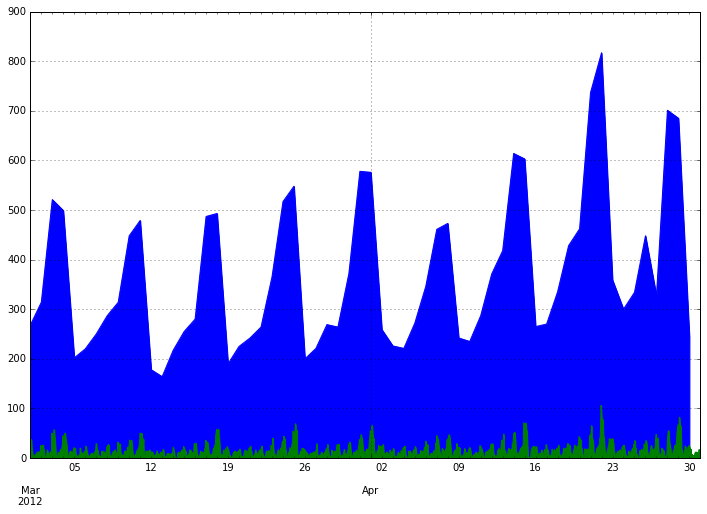

In [7]:
ts_day.plot(figsize = (12,8),kind = 'area');
ts_hour.plot(kind = 'area', grid=True, figsize = (12,8));

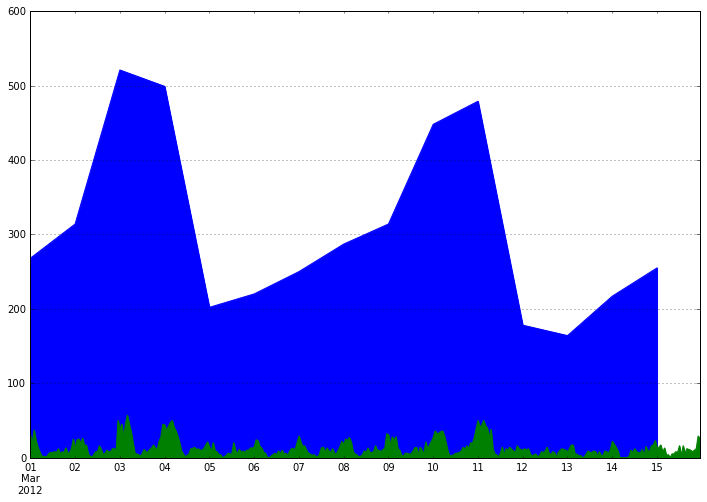

In [8]:
# Zoom in by slicing the index
ts_day['2012-03-01':'2012-03-15'].plot(figsize = (12,8),kind = 'area');
ts_hour['2012-03-01':'2012-03-15'].plot(kind = 'area', grid=True, figsize = (12,8));

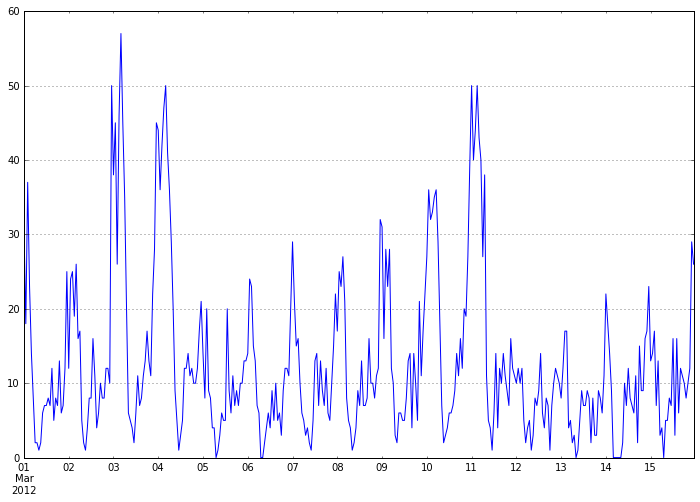

In [9]:
ts_hour['2012-03-01':'2012-03-15'].plot(kind = 'line', grid=True, figsize = (12,8));

#### Create a dataframe that has count and dayofweek features. 

In [10]:
df = pd.DataFrame(ts_day)
df.rename(columns = {0:'count'}, inplace=True)
df.head()

,count
2012-03-01,268
2012-03-02,314
2012-03-03,521
2012-03-04,499
2012-03-05,202


In [11]:
df['weekofday'] = pd.DatetimeIndex(df.index).weekday
# Or use the following
#df['weekofday'] = pd.to_datetime(df.index).weekday

In [12]:
df['weekend'] = df['weekofday']>=5
df.head()

,count,weekofday,weekend
2012-03-01,268,3,False
2012-03-02,314,4,False
2012-03-03,521,5,True
2012-03-04,499,6,True
2012-03-05,202,0,False


In [13]:
#filter or masking
df[df['weekofday']>=5]['count'].sum()

10237

In [14]:
df[df['weekofday']<5]['count'].sum()

12210

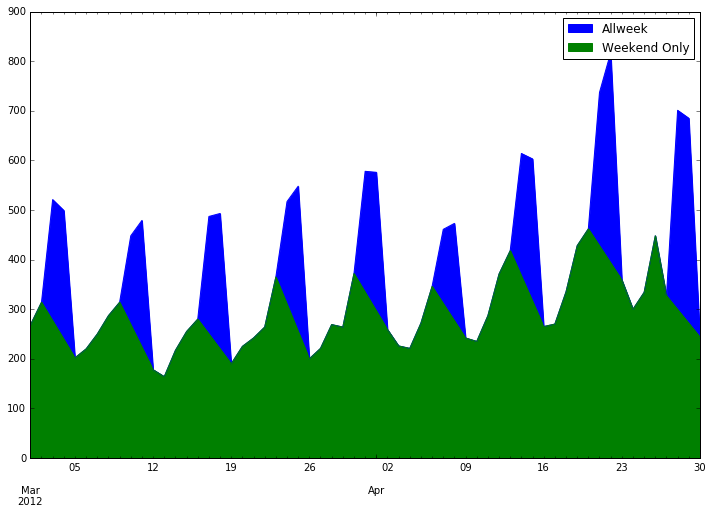

In [15]:
df['count'].plot(figsize=(12,8),kind = 'area', label = 'Allweek')
df[df['weekofday']<5]['count'].plot(kind='area',label = 'Weekend Only')
plt.legend();

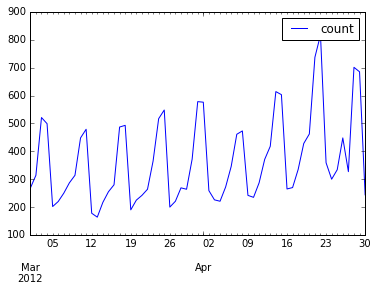

In [16]:
df.plot(df.index, y = 'count')
plt.legend();

#### Show strong seasonal component to the data. I'd be willing to bet that the peaks are weekend demand. Let's see if that's true by highlighting the weekends on our plot with fill_between weekend.

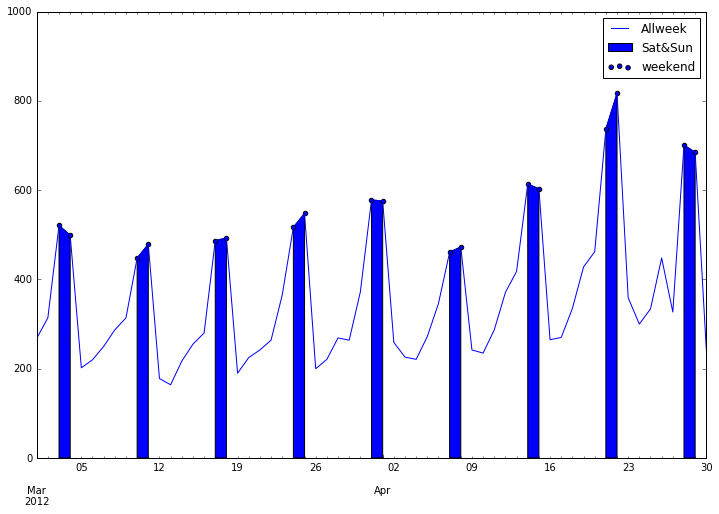

In [17]:
df['count'].plot(figsize=(12,8),kind = 'line', label = 'Allweek')
plt.fill_between(df.index, df['count'], where = df['weekend'], label = 'Sat&Sun')
df1 = df[df['weekofday']>=5]
plt.scatter(x = df1.index, y = df1['count'], label = 'weekend')
# df1['count'].plot(kind = 'area')
plt.ylim(0,1000)
plt.legend();

### Box-Jenkins Methodology

* determine if the data is stationary
* Plot the ACF/PACF with 28 lags (Approx. 4 weeks -- See snippet of code below)

In [18]:
y = ts_day.values
X = range(1, ts_day.shape[0]+1)
model = sm.OLS(y, sm.add_constant(X)).fit()

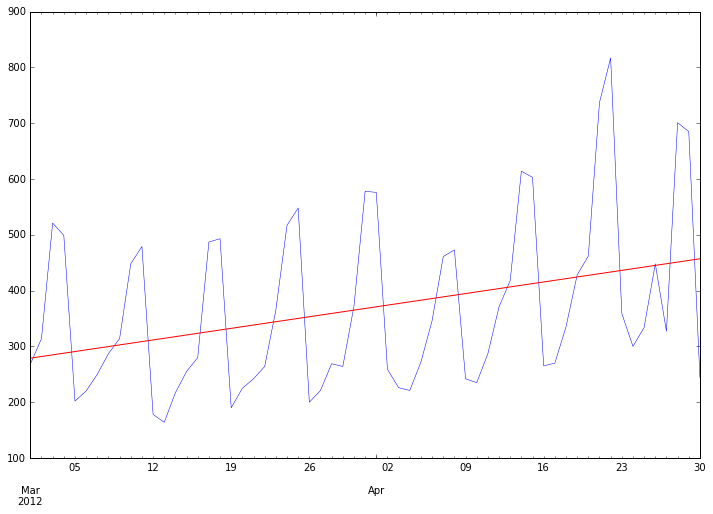

In [19]:
ts_day.plot(figsize=(12,8), lw=0.5)
pd.Series(model.fittedvalues, index=ts_day.index).plot(style='r')